# Exploration of A Prototypical Non Linear System - Duffing's Equation

## Cubic Non Linear Equation - Duffing's Equation (Postive Stiffness)

In [1]:
# This system models a forced pendulum
import sympy as sp
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import fsolve

Here is the Duffing equation as posed by Nayfeh and Mook 4.1.1 with 4.1.5

In [2]:
# Define the symbolic parameters 
epsilon = sp.symbols('epsilon')
mu = sp.symbols('mu')
omega_0 = sp.symbols('omega_0')
alpha = sp.symbols('alpha')
k = sp.symbols('k')
sigma = sp.symbols('sigma')

# Define time variable
t = sp.symbols('t')

# Define function variable 
u = sp.Function('u')(t)
udot = sp.Derivative(u, t)  # first time derivative 
uddot = sp.Derivative(udot, t)  # second time derivative

# Duffing equation 
duffing_diff_eq_LHS = uddot + 2 * epsilon * mu * udot + omega_0**2 * u + epsilon * alpha * u**3
duffing_diff_eq_RHS = epsilon * k * sp.cos(epsilon * sigma * t + t * omega_0)
duffing_diff_eq = sp.Eq(duffing_diff_eq_LHS, duffing_diff_eq_RHS)
duffing_diff_eq

Eq(alpha*epsilon*u(t)**3 + 2*epsilon*mu*Derivative(u(t), t) + omega_0**2*u(t) + Derivative(u(t), (t, 2)), epsilon*k*cos(epsilon*sigma*t + omega_0*t))

See Nayfeh and Mook, pg. 165 --- This is the amplitude-detuning relationship from the multiple scales solution approach 

In [3]:
a = sp.symbols('a')
perturbation_result_LHS = (mu**2 + (sigma - 3 * alpha * a**2 / 8 / omega_0)**2) * a**2 
perturbation_result_RHS = k**2 / 4 / omega_0**2
perturbation_result = sp.Eq(perturbation_result_LHS, perturbation_result_RHS)
perturbation_result

Eq(a**2*(mu**2 + (-3*a**2*alpha/(8*omega_0) + sigma)**2), k**2/(4*omega_0**2))

A chosen paramter set to aid in arrivin at numbers

In [4]:
case0 = perturbation_result.subs([
    (sigma, 5.0), (alpha, 1.0),
    (omega_0, 1.0), (k, 10.0), (mu, 0.35)
])
sp.solve(case0, a**2)

[1.20059779791776 + 0.e-20*I,
 8.98393011153698 + 0.e-19*I,
 16.4821387572119 - 0.e-22*I]

(The Duffing's equation is not solvable using Sympy so we will solve it with a numerical approach.)

If the system variables are defined as 

$u = x_1$ and $\dot{u} = x_2$

then the system equations become

\begin{align*}
    \dot{x}_1 &= x_2 \\
    \dot{x}_2 &= -\omega_0^2 x_1 - \alpha\epsilon x_1^3 - 2\epsilon\mu x_2 + \epsilon k \cos(\epsilon\sigma t + \omega_0 t)
\end{align*}

In [5]:
del epsilon, sigma, alpha, omega_0, k, mu

In [6]:
def duffing(t, u, epsilon, sigma, alpha, omega_0, k, mu):
    return [
        u[1],
        (-omega_0**2 * u[0] - alpha * epsilon * u[0]**3 - 2 * epsilon * mu * u[1]
        + epsilon * k * np.cos(epsilon * sigma * t + omega_0 * t))
    ]

def solve_duffing(func, t, tspan, ic, parameters, algorithm='DOP853'):
    return solve_ivp(fun=func, t_span=tspan, t_eval=t, y0=ic, method=algorithm, 
                     args=tuple(parameters.values()), atol=1e-8, rtol=1e-5)

Low-energy Solution (see ICs)

In [7]:
IC = [0.0, 0.0]  # initial conditions
t = np.linspace(0, 175, 10000)
tspan = (np.min(t), np.max(t))
params = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 1.0,
    'omega_0': 1.0,
    'k': 10.0,
    'mu': 0.35
}
sol_low = solve_duffing(duffing, t, tspan, IC, params)

High-energy solution (see ICs)

In [8]:
IC = [3.0, 0.0]  # initial conditions
sol_high = solve_duffing(duffing, t, tspan, IC, params)

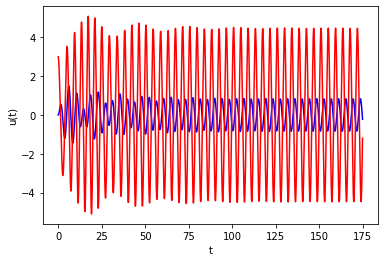

In [9]:
# Plotting
plt.plot(sol_low.t, sol_low.y[0, :], '-b')
plt.plot(sol_high.t, sol_high.y[0, :], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

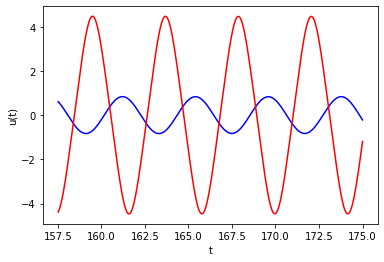

In [10]:
# Plotting close-up
plt.plot(sol_low.t[-1000::], sol_low.y[0, -1000::], '-b')
plt.plot(sol_high.t[-1000::], sol_high.y[0, -1000::], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

Given a value for detuning sigma=x, this calculates the solutions to the amplitude-detuning perturbation solution and then returns the maximum, middle, and minimum real solution (throws away complex solutions)

In [51]:
def solve_perturbation(x, A, W, K, MU):
    # Solves using SymPy
    mu = sp.symbols('mu')
    omega_0 = sp.symbols('omega_0')
    alpha = sp.symbols('alpha')
    k = sp.symbols('k')
    sigma = sp.symbols('sigma')
    a = sp.symbols('a')
    
    perturbation_result_LHS = (mu**2 + (sigma - 3 * alpha * a**2 / 8 / omega_0)**2) * a**2 
    perturbation_result_RHS = k**2 / 4 / omega_0**2
    perturbation_result = sp.Eq(perturbation_result_LHS, perturbation_result_RHS)
    case = perturbation_result.subs([
        (sigma, x), (alpha, A),
        (omega_0, W), (k, K), (mu, MU)
    ])
    sol = sp.solve(case, a**2)
    RE = np.array(list(map(sp.re, sol)), dtype=np.float32)
    return np.lib.scimath.sqrt(RE)

def duffing_amplitude(X, A, W, K, MU):
    vec_solve_perturbation = np.vectorize(solve_perturbation, 
                                          excluded=['A', 'W', 'K', 'MU'],
                                          otypes=[np.ndarray])
    sol = vec_solve_perturbation(X, A, W, K, MU)
    maxSols, minSols, midSols = [], [], []
    maxSol, minSol, midSol = 0, 0, 0
    idx_min, idx_mid = [], []
    for i, row in enumerate(sol):
        rowvals = []
        for val in row:
            if np.around(np.imag(val)) == 0 and np.real(val) > 0:
                maxSol = max(maxSol, val)
                rowvals.append(np.real(val))
        maxSols.append(np.real(maxSol))
        unq_vals = np.unique(rowvals)
        if len(unq_vals) >= 3:
            minSols.append(unq_vals[0])
            idx_min.append(i)

            midSols.append(unq_vals[1])
            idx_mid.append(i)
    return np.array(maxSols), np.array(minSols), np.array(midSols), np.array(idx_min), np.array(idx_mid) 

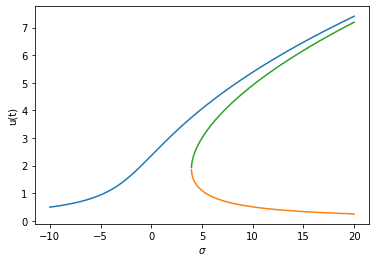

In [50]:
x = np.linspace(-10, 20, 1000)
max_amps, min_amps, mid_amps, idx_min, idx_mid = duffing_amplitude(x, 1.0, 1.0, 10.0, 0.35)
plt.plot(x, max_amps)
plt.plot(x[idx_min], min_amps)
plt.plot(x[idx_mid], mid_amps)
plt.ylabel('u(t)')
plt.xlabel(r'$\sigma$')
plt.show()

## Linear vs. Nonlinear Response

### Linear Response - Effect of Amplitude

In [53]:
IC = [0.0, 0.0]  # initial conditions
t = np.linspace(0, 175, 10000)
tspan = (np.min(t), np.max(t))
params1 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 0.0,
    'omega_0': 1.0,
    'k': 10.0,
    'mu': 0.35
}
params2 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 0.0,
    'omega_0': 1.0,
    'k': 100.0,
    'mu': 0.35
}
params3 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 0.0,
    'omega_0': 1.0,
    'k': 1000.0,
    'mu': 0.35
}

In [54]:
p1_linear = solve_duffing(duffing, t, tspan, IC, params1)
p2_linear = solve_duffing(duffing, t, tspan, IC, params2)
p3_linear = solve_duffing(duffing, t, tspan, IC, params3)

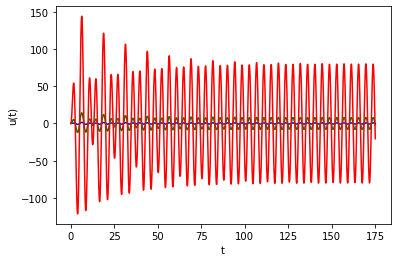

In [55]:
# Plotting
plt.plot(p1_linear.t, p1_linear.y[0, :], '-b')
plt.plot(p2_linear.t, p2_linear.y[0, :], '-g')
plt.plot(p3_linear.t, p3_linear.y[0, :], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

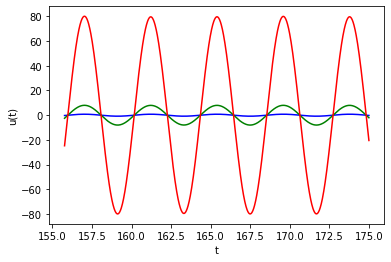

In [56]:
# Plotting
plt.plot(p1_linear.t[-1100::], p1_linear.y[0, -1100::], '-b')
plt.plot(p2_linear.t[-1100::], p2_linear.y[0, -1100::], '-g')
plt.plot(p3_linear.t[-1100::], p3_linear.y[0, -1100::], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

### Nonlinear Response - Effect of Amplitude (low energy ICs)

In [59]:
IC = [0.0, 0.0]  # initial conditions
t = np.linspace(0, 175, 10000)
tspan = (np.min(t), np.max(t))
params1 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 1.0,
    'omega_0': 1.0,
    'k': 10.0,
    'mu': 0.35
}
params2 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 1.0,
    'omega_0': 1.0,
    'k': 100.0,
    'mu': 0.35
}
params3 = {
    'epsilon': 0.1,
    'sigma': 5.0,
    'alpha': 1.0,
    'omega_0': 1.0,
    'k': 1000.0,
    'mu': 0.35
}

In [60]:
p1_nonlinear = solve_duffing(duffing, t, tspan, IC, params1)
p2_nonlinear = solve_duffing(duffing, t, tspan, IC, params2)
p3_nonlinear = solve_duffing(duffing, t, tspan, IC, params3)

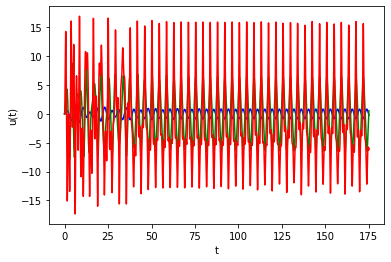

In [61]:
# Plotting
plt.plot(p1_nonlinear.t, p1_nonlinear.y[0, :], '-b')
plt.plot(p2_nonlinear.t, p2_nonlinear.y[0, :], '-g')
plt.plot(p3_nonlinear.t, p3_nonlinear.y[0, :], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

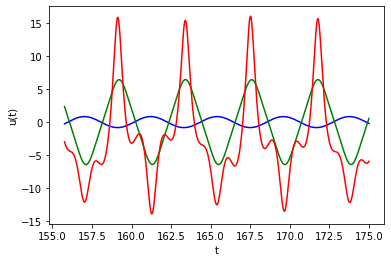

In [62]:
# Plotting
plt.plot(p1_nonlinear.t[-1100::], p1_nonlinear.y[0, -1100::], '-b')
plt.plot(p2_nonlinear.t[-1100::], p2_nonlinear.y[0, -1100::], '-g')
plt.plot(p3_nonlinear.t[-1100::], p3_nonlinear.y[0, -1100::], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

### Weakly forced linear vs. nonlinear

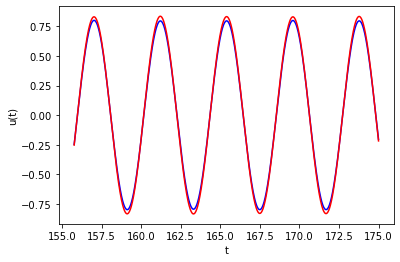

In [64]:
# Plotting
plt.plot(p1_linear.t[-1100::], p1_linear.y[0, -1100::], '-b')
plt.plot(p1_nonlinear.t[-1100::], p1_nonlinear.y[0, -1100::], '-r')
plt.xlabel('t')
plt.ylabel('u(t)')
plt.show()

## Chaotic System - Harmonically Forced Duffing (Negative Stiffness)

In [75]:
def invPendulum_linear(t, u, omega, k, mu):
    # inverted pendulum
    return [
        u[1],
        u[0] - 2 * mu * u[1] + k * np.cos(omega * t)
    ]

def solve_diffeq(func, t, tspan, ic, parameters, algorithm='DOP853'):
    return solve_ivp(fun=func, t_span=tspan, t_eval=t, y0=ic, method=algorithm, 
                     args=tuple(parameters.values()), atol=1e-8, rtol=1e-5)

Linear system - unstable

In [76]:
params = {
    'omega': 1.25,
    'k': 0.2,
    'mu': 0.15
}

Text(0, 0.5, 'y')

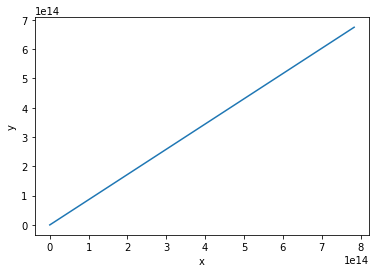

In [77]:
# Solve
IC = [1, 0.5]
t = np.linspace(0, 40, 1000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_linear, t, tspan, IC, params)

# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

Nonlinear system - k = 0.2

In [78]:
params = {
    'omega': 1.25,
    'k': 0.2,
    'mu': 0.15
}

In [81]:
def invPendulum_nonlinear(t, u, omega, k, mu):
    # inverted pendulum
    return [
        u[1],
        u[0] - 2 * mu * u[1] - u[0] ** 3 + k * np.cos(omega * t)
    ]

Text(0, 0.5, 'y')

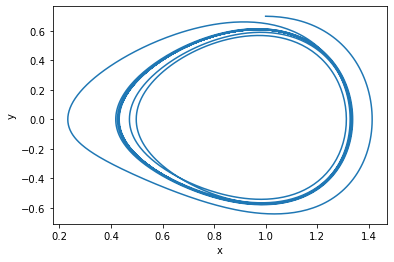

In [82]:
# Solve
IC = [1, 0.7]
t = np.linspace(0, 100, 5000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

By changing the IC we can get to a stable orbit in the left half-plane

Text(0, 0.5, 'y')

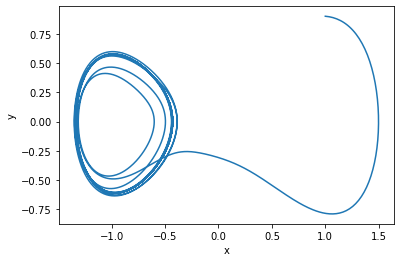

In [83]:
# Solve
IC = [1, 0.9]
t = np.linspace(0, 100, 5000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

Produce a Poincare section

In [91]:
# Solve
IC = [1, 0.5]
omega = 1.25
imax = 500
t = np.linspace(0, imax * 2 * np.pi / omega, imax**2)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)

In [92]:
def poincare_section(imax, x, y):
    xs = [x[imax * i] for i in range(imax)]
    ys = [y[imax * i] for i in range(imax)]
    return xs, ys

In [93]:
xs, ys = poincare_section(imax, res.y[0, :], res.y[1, :])

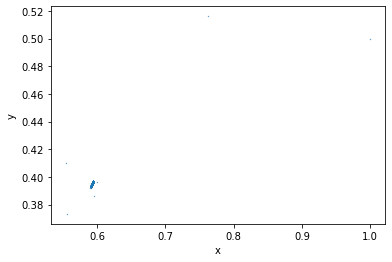

In [94]:
# Plotting
plt.scatter(xs, ys, s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Nonlinear system - k = 0.3

In [96]:
params = {
    'omega': 1.25,
    'k': 0.3,
    'mu': 0.15
}

Text(0, 0.5, 'y')

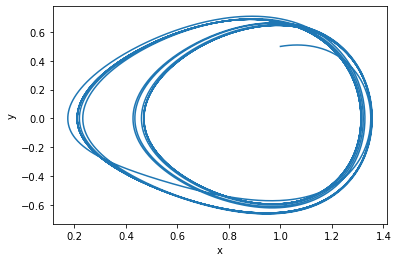

In [98]:
IC = [1, 0.5]
t = np.linspace(0, 80, 5000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

In [99]:
omega = 1.25
imax = 100
t = np.linspace(0, imax * 2 * np.pi / omega, imax**2)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)

In [100]:
xs, ys = poincare_section(imax, res.y[0, :], res.y[1, :])

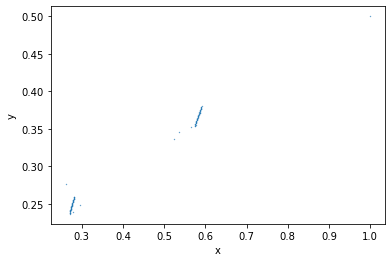

In [101]:
# Plotting
plt.scatter(xs, ys, s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Nonlinear system - k = 0.5

Text(0, 0.5, 'y')

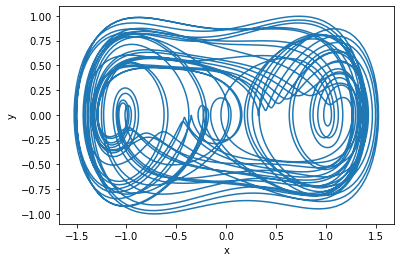

In [102]:
params = {
    'omega': 1.25,
    'k': 0.5,
    'mu': 0.15
}
IC = [1, 0.5]
t = np.linspace(0, 300, 5000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

Plot for 10X in time

Text(0, 0.5, 'y')

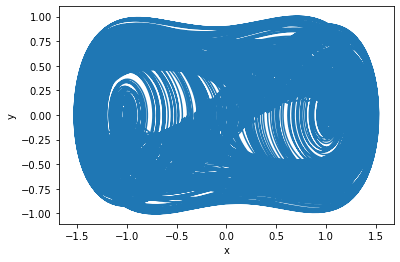

In [103]:
t = np.linspace(0, 300*10, 50000)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
# Plotting
plt.plot(res.y[0, :], res.y[1, :])
plt.xlabel('x')
plt.ylabel('y')

Plot the Poincare section - hidden order, self-similar and fractal (Strange Attractor)

In [108]:
omega = 1.25
imax = 10000
t = np.linspace(0, imax * 2 * np.pi / omega, imax**2)
tspan = (np.min(t), np.max(t))
res = solve_diffeq(invPendulum_nonlinear, t, tspan, IC, params)
xs, ys = poincare_section(imax, res.y[0, :], res.y[1, :])

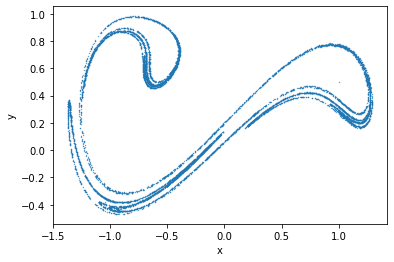

In [109]:
# Plotting
plt.scatter(xs, ys, s=0.1)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

# Courtesy

- Prof. Michael Joseph Leamy, ME 6444, Georgia Institute of Technology
- Stephen Lynch, Dynamical Systems with Applications using Python, 2018